In [1]:
import pandas as pd

In [2]:
path = 'simpsons_script_lines.csv'

In [3]:
df = pd.read_csv(path)

/var/folders/0q/132d4mqx32z7hhp3qh_g3vrm0000gn/T/ipykernel_25783/3280352130.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
df.raw_character_text.value_counts()[:100]

Homer Simpson            29842
Marge Simpson            14159
Bart Simpson             13777
Lisa Simpson             11502
C. Montgomery Burns       3172
                         ...  
Santa's Little Helper       74
Annie Crawford              74
Artie Ziff                  73
Young Marge                 72
George H.W. Bush            72
Name: raw_character_text, Length: 100, dtype: int64

In [5]:
episodes = 'simpsons_episodes.csv'

In [6]:
ep_df = pd.read_csv(episodes)

In [62]:
ep_df.season.value_counts()

6     25
7     25
8     25
9     25
3     24
10    23
21    23
15    22
17    22
25    22
24    22
23    22
22    22
18    22
14    22
2     22
27    22
13    22
11    22
5     22
4     22
26    22
16    21
20    21
12    21
19    20
1     13
28     4
Name: season, dtype: int64

In [8]:
good_season_episodes = ep_df[ep_df['season'] <= 12]

In [9]:
good_df = df[df.episode_id.isin(good_season_episodes.id)]

In [10]:
good_df.raw_character_text.value_counts()

Homer Simpson          15346
Bart Simpson            7501
Marge Simpson           6721
Lisa Simpson            5571
C. Montgomery Burns     1827
                       ...  
Mutant Sideshow Mel        1
Man At Bar                 1
Little Girls               1
Young Barney               1
Passerby                   1
Name: raw_character_text, Length: 3371, dtype: int64

K. So what does a pipeline look like here? 

Take script for good season. Sort it by episode and then by date. 

For (episode), go through and generate a "prompt": "line... CHAR:" ... "completion": "text" 

Trailing context - start with 5 lines, make this configurable

For every line, if `raw_character_text` is not in top 50 characters, replace with "NPC"

In [11]:
good_df = good_df.sort_values(by='id')

In [12]:
good_df.raw_character_text = good_df.raw_character_text.fillna('Nobody')

In [13]:
good_df.raw_character_text.value_counts()[:50].index.values

array(['Homer Simpson', 'Nobody', 'Bart Simpson', 'Marge Simpson',
       'Lisa Simpson', 'C. Montgomery Burns', 'Seymour Skinner',
       'Moe Szyslak', 'Ned Flanders', 'Grampa Simpson',
       'Krusty the Clown', 'Chief Wiggum', 'Milhouse Van Houten',
       'Waylon Smithers', 'Apu Nahasapeemapetilon', 'Kent Brockman',
       'Nelson Muntz', 'Barney Gumble', 'Lenny Leonard',
       'Edna Krabappel-Flanders', 'Sideshow Bob', 'Dr. Julius Hibbert',
       'Selma Bouvier', 'Ralph Wiggum', 'Rev. Timothy Lovejoy', 'Crowd',
       'Carl Carlson', 'Patty Bouvier', 'Mayor Joe Quimby', 'Otto Mann',
       'Groundskeeper Willie', 'Martin Prince', 'Announcer',
       'Comic Book Guy', 'Kids', 'Lionel Hutz', 'HERB', 'Sideshow Mel',
       'Gary Chalmers', 'Professor Jonathan Frink', 'Jimbo Jones', 'Lou',
       'Todd Flanders', 'Miss Hoover', 'Agnes Skinner', 'Maude Flanders',
       'Troy McClure', 'Fat Tony', 'Snake Jailbird', 'TROY'], dtype=object)

In [14]:
import numpy as np

This fills in actions

In [15]:
good_df.spoken_words = good_df.spoken_words.fillna('nan')

In [16]:
sub_df = good_df[good_df.apply(lambda r: r.spoken_words == 'nan' and r.raw_character_text != 'Nobody', axis=1)]

In [17]:
new_spoken_words = sub_df.apply(lambda r: r.raw_text.split(":")[1], axis=1)

In [18]:
def add_actions(r):
    if r.spoken_words == 'nan' and r.raw_character_text != 'Nobody':
        return r.raw_text.split(":")[-1]
    return r.spoken_words

In [19]:
good_df.spoken_words = good_df.apply(lambda r: add_actions(r), axis=1)

Next, we want to figure out how many tokens are in a set of lines

In [22]:
import transformers

In [21]:
from transformers import AutoTokenizer

/Users/dan/miniconda3/envs/base_ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


llama is finicky, this is basically the same

In [22]:
tok = AutoTokenizer.from_pretrained('google/flan-t5-xl')

A token is basically a token

In [34]:
import numpy as np

How many lines does it take to get to 1500 tokens? 

In [26]:
for samp in range(2):
    n = np.random.randint(good_df.shape[0])
    orig_n = n
    n_tokens = 0
    while n_tokens < 1500:
        text = good_df.iloc[n].spoken_words
        #print(f'text: {text}')
        tokenized = tok(text, return_tensors='pt').input_ids
        #print(f'tokenized {tokenized}')
        n_tokens += tokenized.shape[1]
        n+=1
    print(f'tokens: {n_tokens}')
    print(f'n lines: {n - orig_n}')

tokens: 1514
n lines: 91
tokens: 1509
n lines: 121


Calculate number of tokens. 

In [30]:
def max_scenes(df):
    cur_scene = []
    big_tuples = []
    for ind, line in df.iterrows():
        if line.raw_character_text == 'Nobody':
            n_tokens = len(tok(' '.join(cur_scene))['input_ids'])
            big_tuples.append((len(cur_scene), n_tokens))
            cur_scene = []
        else:
            cur_scene.append(line.spoken_words)
    return big_tuples

In [31]:
res = max_scenes(good_df)

In [34]:
lines_per_scene = [val[0] for val in res if val[0] > 0 ]

In [60]:
total_tokens = sum([val[1] for val in res])

In [61]:
total_tokens

1113577

In [37]:
tokens_per_scene = [val[1] for val in res if val[0] > 0 ]

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'Lines per scene in The Simpsons')

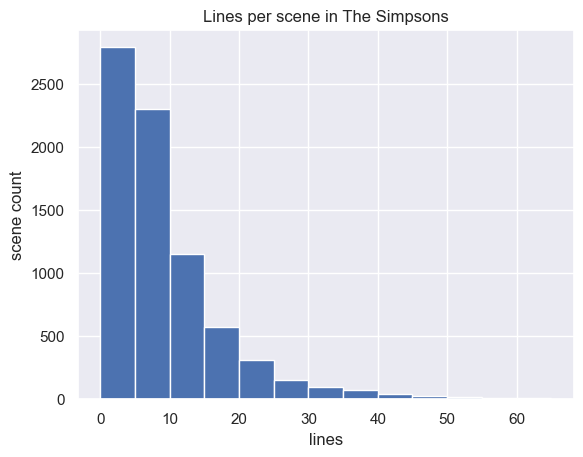

In [51]:
plt.hist(lines_per_scene, bins=np.arange(0, 70, 5))
plt.xlabel('lines')
plt.ylabel('scene count')
plt.title('Lines per scene in The Simpsons')

Text(0.5, 1.0, 'Tokens per scene in The Simpsons')

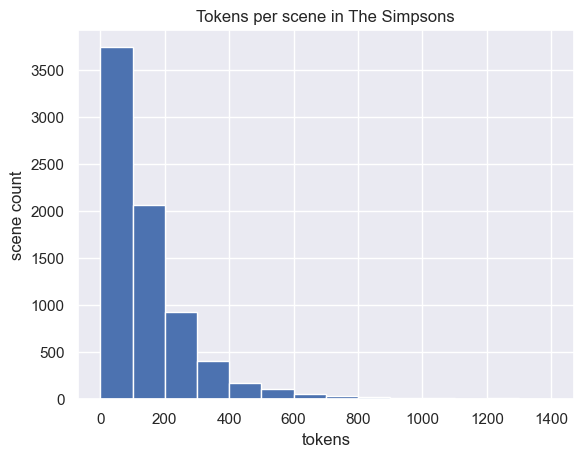

In [52]:
plt.hist(tokens_per_scene, bins = np.arange(0,1500, 100))
plt.xlabel('tokens')
plt.ylabel('scene count')
plt.title('Tokens per scene in The Simpsons')

I say let's take 50 lines. Still arbitrary. 

In [53]:
CONTEXT_LINES = 50

In [54]:
def generate_data(df):
    cur_scene = []
    for ind, line in df.iterrows():
        if line.raw_character_text == 'Nobody':
            process_scene(cur_scene)
            cur_scene = []
        else:
            cur_scene.append((line.raw_character_text, line.spoken_words))

In [55]:
data = []

In [56]:
def build_text(preamble):
    return '\n'.join([f"{char}: {text}" for char, text in preamble])

def process_scene(cur_scene):
    if len(cur_scene) <= 1:
        return
    for ind in range(1, len(cur_scene)):
        prompt = build_text(cur_scene[max(0, ind-CONTEXT_LINES):ind])
        cur_char, cur_text = cur_scene[ind]
        data.append({'p': prompt, 'c': cur_char, 'l': cur_text})
        
        
        

In [57]:
generate_data(good_df)

In [58]:
len(data)

61884

great, works. Fantastic, no notes. 

In [98]:
with open('processed_conversations/simpsons_data_two.json', 'w') as f:
    json.dump(data, f)

In [100]:
data[0]

('Marge Simpson: Ooo, careful, Homer.\nHomer Simpson:',
 "There's no time to be careful.")

In [106]:
len(data)

61884

In [107]:
import numpy as np

In [95]:
for val in range(10):
    print('\n')
    sample = data[np.random.randint(len(data))]
    print(sample)



{'p': 'Seymour Skinner: Now, hold it right there you...', 'c': 'Agnes Skinner', 'l': 'Spanky...'}


{'p': "Homer Simpson: Oh, yeah. That's it, baby, that's the money shot. Yeah, the camera loves you. Oh-ho-ho, you tease, you.", 'c': 'Bart Simpson', 'l': 'Why are you taping Flanders, Dad?'}


{'p': "Bart Simpson: If you gain 61 pounds, they'll let you work at home?\nHomer Simpson: Yuh-huh, that's the deal. No more exercise program! No more traffic! No more blood drives or charity walks!", 'c': 'Bart Simpson', 'l': "Dad, I know we don't do a lot together, but helping you gain 61 pounds is something I want to be a part of."}


{'p': "Rick: 'Pretty cool of your mom to let us hang out here.\nErin: Totally. Not like my mom. She'd be butting in with rice crispie squares and Tang.\nRick: My dad's all stoked 'cause today's the Fourth of July. He woke me up at dawn to take a loyalty oath.\nDean: My mom's French, so we only celebrate Bastille Day.\nLisa Simpson: Well, we could do something fun.